In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Real Estate Price Prediction - XGBoost Model

This notebook demonstrates a complete ML pipeline for predicting real estate prices using XGBoost:
1. **Data Loading** - Load and extract data from JSON
2. **Exploratory Data Analysis (EDA)** - Understand data distribution and relationships
3. **Data Preprocessing** - Handle missing values, encode categorical features
4. **Model Training** - Train baseline XGBoost model
5. **Hyperparameter Tuning** - Optimize model performance
6. **Model Evaluation** - Assess final model performance

## 1. Data Loading

In [32]:
# Load Data
path = Path('..') / 'preprocessing' / 'preprocessed_listings.csv'

# Create DataFrame
df = pd.read_csv(path)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (4658, 39)

First few rows:


,price_czk,city,district,street,zip_code,layout,building_type,condition,ownership,floor,...,desc_has_shopping,desc_is_quiet,desc_is_sunny,desc_has_ac,desc_has_fireplace,desc_has_floor_heating,desc_is_renovated,desc_is_new_building,is_renovated,is_new_building
0,8870000.0,Praha,Praha 4,Machkova,14900.0,3+kk,Panelová,Po rekonstrukci,Osobní,2.0,...,True,True,False,False,False,False,True,True,True,True
1,0.0,Praha,Praha 9,Podzámecká,19016.0,4+kk,Cihlová,Novostavba,Osobní,1.0,...,False,True,False,False,False,False,False,False,False,True
2,7490000.0,Praha,Praha 7,Veverkova,17000.0,1+kk,Smíšená,Velmi dobrý,Osobní,8.0,...,True,True,False,False,False,False,True,False,True,False
3,17490000.0,Praha,Praha 5,náměstí Pod lípou,15400.0,4+kk,Cihlová,Novostavba,Osobní,3.0,...,False,True,False,False,False,True,False,False,False,True
4,10399900.0,Praha,Praha 3,Chrudimská,13000.0,2+kk,Cihlová,Velmi dobrý,Osobní,6.0,...,True,True,True,False,False,False,True,False,True,False


## 2. Exploratory Data Analysis (EDA)

In [33]:
# Basic dataset information
print("Dataset Information:")
print(f"Total records: {len(df)}")
print("===========================")
print(f"Data types:{df.dtypes.value_counts()}")
print("===========================")
print(f"Missing values:{df.isnull().sum()[df.isnull().sum() > 0]}")
print("===========================")
print(f"Basic statistics:")
df.describe()

Dataset Information:
Total records: 4658
Data types:object     21
float64     9
bool        9
Name: count, dtype: int64
Missing values:price_czk                  212
city                       212
district                   212
street                     350
zip_code                   611
layout                     212
building_type              212
condition                  212
ownership                  212
floor                      212
total_floors              1490
usable_area                212
balcony_area              3775
terrace_area              3853
loggia_area               3827
cellar_area               2886
energy_rating              212
desc_has_metro             212
desc_has_tram              212
desc_has_bus               212
desc_has_park              212
desc_has_school            212
desc_has_shopping          212
desc_is_quiet              212
desc_is_sunny              212
desc_has_ac                212
desc_has_fireplace         212
desc_has_floor_heating     2

,price_czk,zip_code,floor,total_floors,usable_area,balcony_area,terrace_area,loggia_area,cellar_area
count,4.446000e+03,4047.000000,4446.000000,3168.000000,4446.000000,883.000000,805.000000,831.000000,1772.000000
mean,1.171501e+07,13126.775883,3.609537,6.438763,77.918129,7.663647,45.568944,6.870036,4.138826
std,7.684960e+06,5681.658395,2.564978,3.092619,43.074760,7.218575,217.679826,5.477442,4.979679
min,0.000000e+00,-1.000000,-2.000000,1.000000,15.000000,1.000000,3.000000,1.000000,-2.000000
25%,7.698456e+06,11000.000000,2.000000,4.000000,52.000000,4.000000,13.000000,4.000000,2.000000
50%,9.900000e+06,14900.000000,3.000000,6.000000,68.000000,6.000000,26.000000,6.000000,3.000000
75%,1.398000e+07,16900.000000,5.000000,8.000000,92.000000,9.000000,43.000000,8.000000,5.000000
max,1.050000e+08,19900.000000,24.000000,30.000000,536.000000,56.000000,6074.000000,103.000000,95.000000


In [34]:
if 'zip_code' in df.columns:
    df.drop(columns=['zip_code'], inplace=True)

# Remove rows with price NaN or Null
df = df[df['price_czk'].notna()]

df = df[df['price_czk'] > 100_000]

print(f"Dataset shape after removing invalid prices: {df.shape}")

Dataset shape after removing invalid prices: (4262, 38)


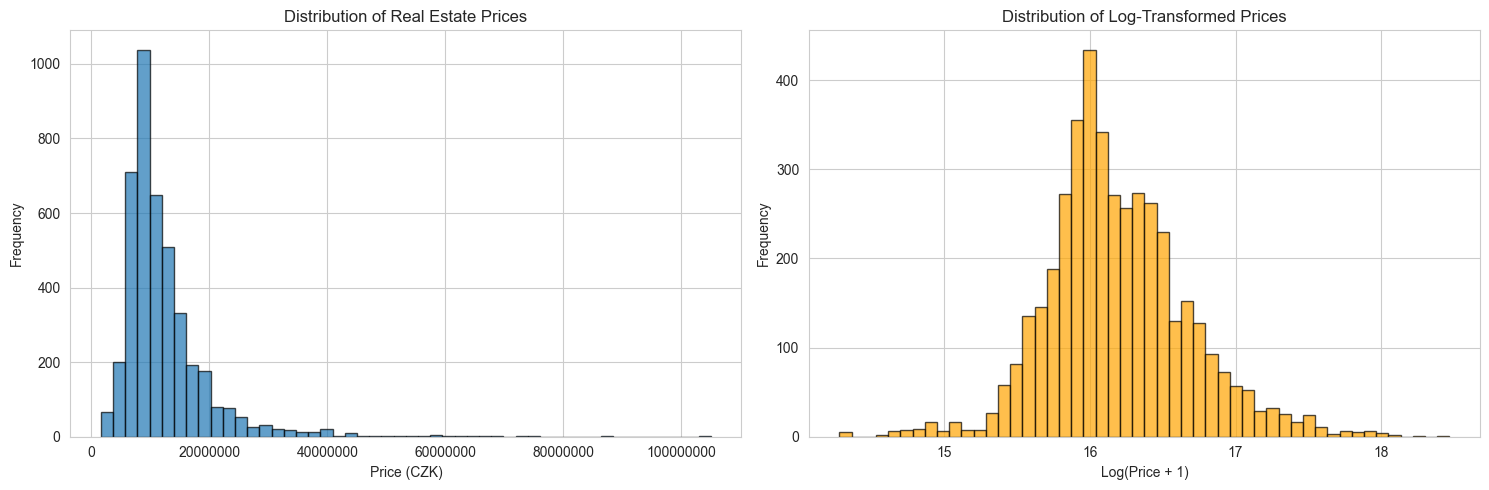

In [35]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Price distribution
axes[0].hist(df['price_czk'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (CZK)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Real Estate Prices')
axes[0].ticklabel_format(style='plain', axis='x')

# Log-transformed price distribution
axes[1].hist(np.log1p(df['price_czk']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Prices')

plt.tight_layout()
plt.show()

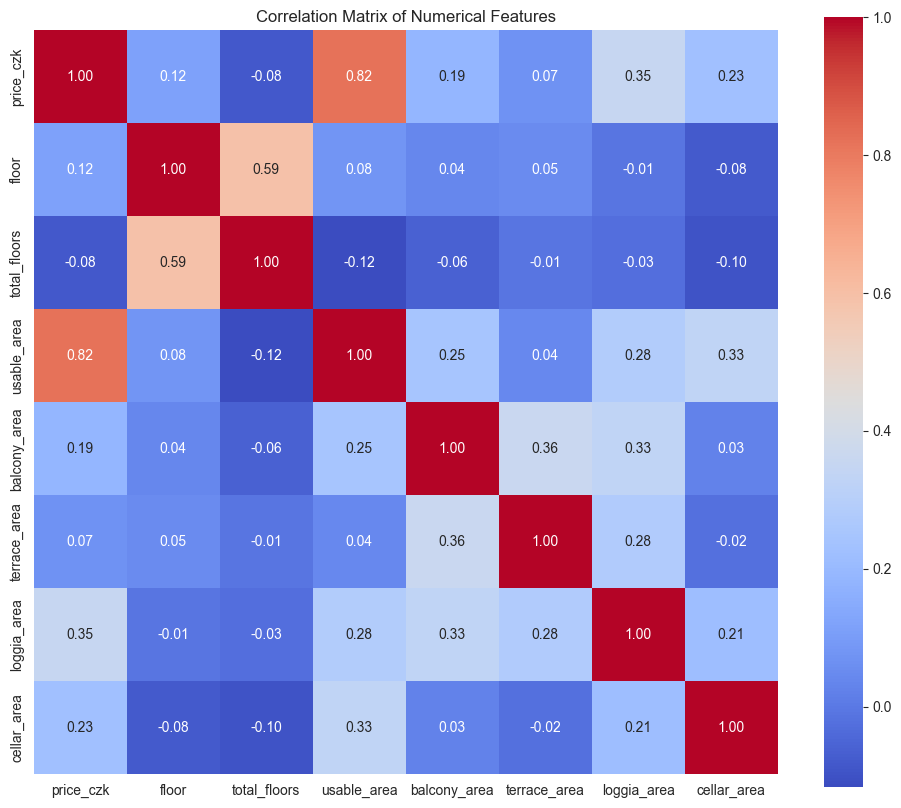

In [36]:
# Correlation analysis for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation with price
correlations = df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [37]:
# Categorical features analysis
categorical_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

if 'city' in categorical_cols:
    categorical_cols.remove('city')

print(f"Categorical features: {len(categorical_cols)}")
print(f"\nUnique values per categorical feature:")
for col in categorical_cols[:10]:  # Show first 10
    print(f"{col}: {df[col].nunique()} unique values")


Categorical features: 29

Unique values per categorical feature:
district: 11 unique values
street: 1320 unique values
layout: 12 unique values
building_type: 8 unique values
condition: 9 unique values
ownership: 3 unique values
has_balcony: 2 unique values
has_terrace: 2 unique values
has_loggia: 2 unique values
has_cellar: 2 unique values


## 3. Data Preprocessing

In [38]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values in numerical features
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('price_czk')  # Exclude target

# Fill missing numerical values with median
for col in numerical_cols:
    if col == 'total_floors':
        continue

    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(0, inplace=True)
        print(f"Filled {col} missing values with 0")

Filled balcony_area missing values with 0
Filled terrace_area missing values with 0
Filled loggia_area missing values with 0
Filled cellar_area missing values with 0


In [39]:
# Encode categorical features
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique classes")

# Convert boolean features to integers
boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()
for col in boolean_cols:
    df_processed[col] = df_processed[col].astype(int)

# Min max scaling for numerical features (excluding price_czk target)
from sklearn.preprocessing import MinMaxScaler

# Get all numerical columns except price_czk
numerical_cols_to_scale = [col for col in df_processed.select_dtypes(include=[np.number]).columns 
                           if col != 'price_czk']

scaler = MinMaxScaler()
df_processed[numerical_cols_to_scale] = scaler.fit_transform(df_processed[numerical_cols_to_scale])

print(f"Scaled {len(numerical_cols_to_scale)} numerical features (price_czk kept in original scale)")


Encoded district: 11 unique classes
Encoded street: 1321 unique classes
Encoded layout: 12 unique classes
Encoded building_type: 8 unique classes
Encoded condition: 9 unique classes
Encoded ownership: 3 unique classes
Encoded has_balcony: 2 unique classes
Encoded has_terrace: 2 unique classes
Encoded has_loggia: 2 unique classes
Encoded has_cellar: 2 unique classes
Encoded has_garage: 2 unique classes
Encoded has_parking: 2 unique classes
Encoded has_elevator: 2 unique classes
Encoded energy_rating: 8 unique classes
Encoded desc_has_metro: 2 unique classes
Encoded desc_has_tram: 2 unique classes
Encoded desc_has_bus: 2 unique classes
Encoded desc_has_park: 2 unique classes
Encoded desc_has_school: 2 unique classes
Encoded desc_has_shopping: 2 unique classes
Encoded desc_is_quiet: 2 unique classes
Encoded desc_is_sunny: 2 unique classes
Encoded desc_has_ac: 2 unique classes
Encoded desc_has_fireplace: 2 unique classes
Encoded desc_has_floor_heating: 2 unique classes
Encoded desc_is_reno

In [40]:
df_processed.drop(columns=['city'], inplace=True)

print(f"\nTotal features after encoding: {df_processed.shape}")
print(f"Feature types:\n{df_processed.dtypes.value_counts()}")
print(f"\nFirst few rows of processed data:")
df_processed.head()


Total features after encoding: (4262, 37)
Feature types:
float64    37
Name: count, dtype: int64

First few rows of processed data:


,price_czk,district,street,layout,building_type,condition,ownership,floor,total_floors,usable_area,...,desc_has_shopping,desc_is_quiet,desc_is_sunny,desc_has_ac,desc_has_fireplace,desc_has_floor_heating,desc_is_renovated,desc_is_new_building,is_renovated,is_new_building
0,8870000.0,0.5,0.359091,0.454545,0.714286,0.250,0.5,0.173913,0.333333,0.118644,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,7490000.0,0.8,0.871212,0.090909,1.000000,0.875,0.5,0.434783,0.333333,0.060533,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,17490000.0,0.6,0.947727,0.636364,0.000000,0.125,0.5,0.217391,0.095238,0.273608,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,10399900.0,0.4,0.077273,0.272727,0.000000,0.875,0.5,0.347826,0.333333,0.072639,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,15999900.0,0.4,0.697727,0.454545,0.000000,0.875,0.5,0.173913,0.238095,0.174334,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:
# Clean data: Remove rows with invalid target values
print(f"Dataset shape before cleaning: {df_processed.shape}")
print(f"NaN in price_czk: {df_processed['price_czk'].isna().sum()}")
print(f"Inf in price_czk: {np.isinf(df_processed['price_czk']).sum()}")

# Remove rows with NaN or infinite values in target
df_processed = df_processed[df_processed['price_czk'].notna()]
df_processed = df_processed[~np.isinf(df_processed['price_czk'])]

print(f"\nDataset shape after cleaning: {df_processed.shape}")
print(f"Rows removed: {len(df) - len(df_processed)}")

Dataset shape before cleaning: (4262, 37)
NaN in price_czk: 0
Inf in price_czk: 0

Dataset shape after cleaning: (4262, 37)
Rows removed: 0


In [42]:
# Update X and y with cleaned data
X = df_processed.drop('price_czk', axis=1)
y = df_processed['price_czk']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nFeature names ({len(X.columns)} total):")
print(list(X.columns))

Training set size: (3409, 36)
Test set size: (853, 36)

Feature names (36 total):
['district', 'street', 'layout', 'building_type', 'condition', 'ownership', 'floor', 'total_floors', 'usable_area', 'balcony_area', 'terrace_area', 'loggia_area', 'cellar_area', 'has_balcony', 'has_terrace', 'has_loggia', 'has_cellar', 'has_garage', 'has_parking', 'has_elevator', 'energy_rating', 'desc_has_metro', 'desc_has_tram', 'desc_has_bus', 'desc_has_park', 'desc_has_school', 'desc_has_shopping', 'desc_is_quiet', 'desc_is_sunny', 'desc_has_ac', 'desc_has_fireplace', 'desc_has_floor_heating', 'desc_is_renovated', 'desc_is_new_building', 'is_renovated', 'is_new_building']


## 4. Baseline Model Training

In [43]:
# Train baseline XGBoost model
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

print("Training baseline XGBoost model...")
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

print("\nBaseline Model Performance:")
print("=" * 50)
print("\nTraining Set:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):,.0f} CZK")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):,.0f} CZK")
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")

print("\nTest Set:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):,.0f} CZK")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):,.0f} CZK")

untuned_r2 = r2_score(y_test, y_pred_test)

print(f"R² Score: {untuned_r2:.4f}")

Training baseline XGBoost model...

Baseline Model Performance:

Training Set:
RMSE: 1,098,791 CZK
MAE: 753,587 CZK
R² Score: 0.9769

Test Set:
RMSE: 4,166,139 CZK
MAE: 1,675,709 CZK
R² Score: 0.7451


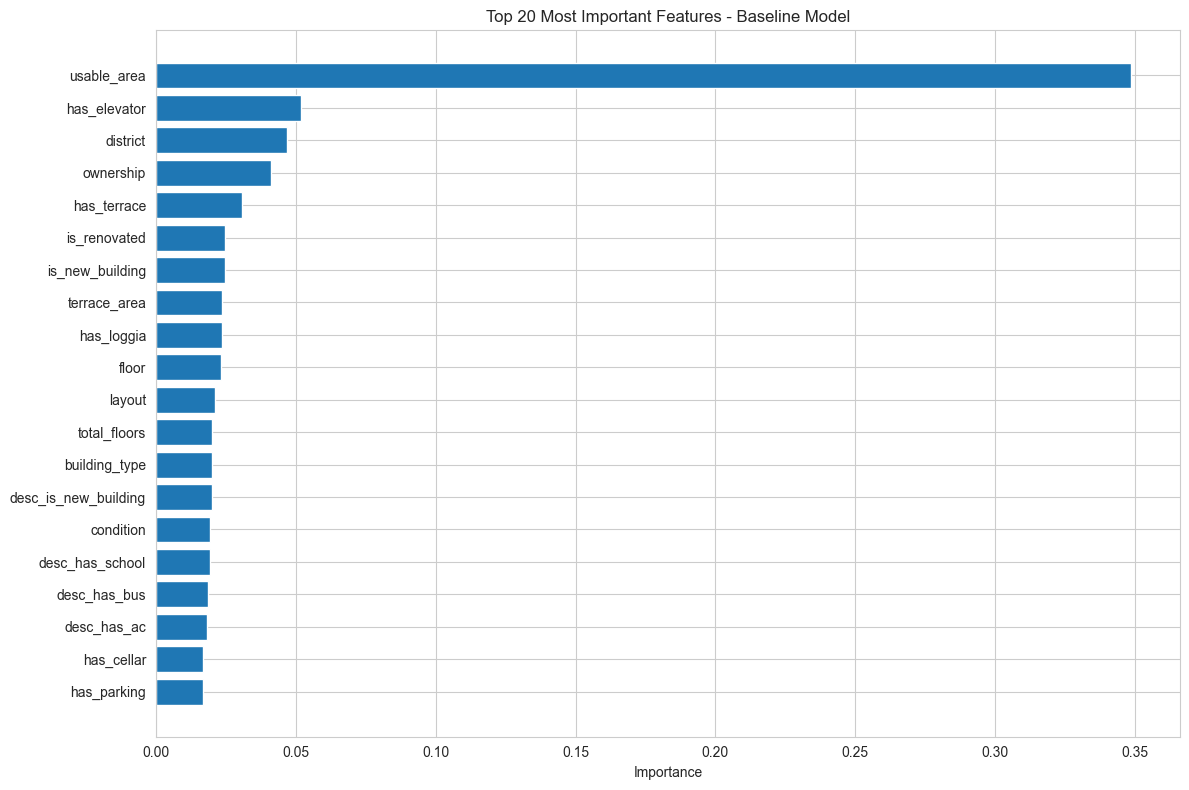

In [44]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features - Baseline Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

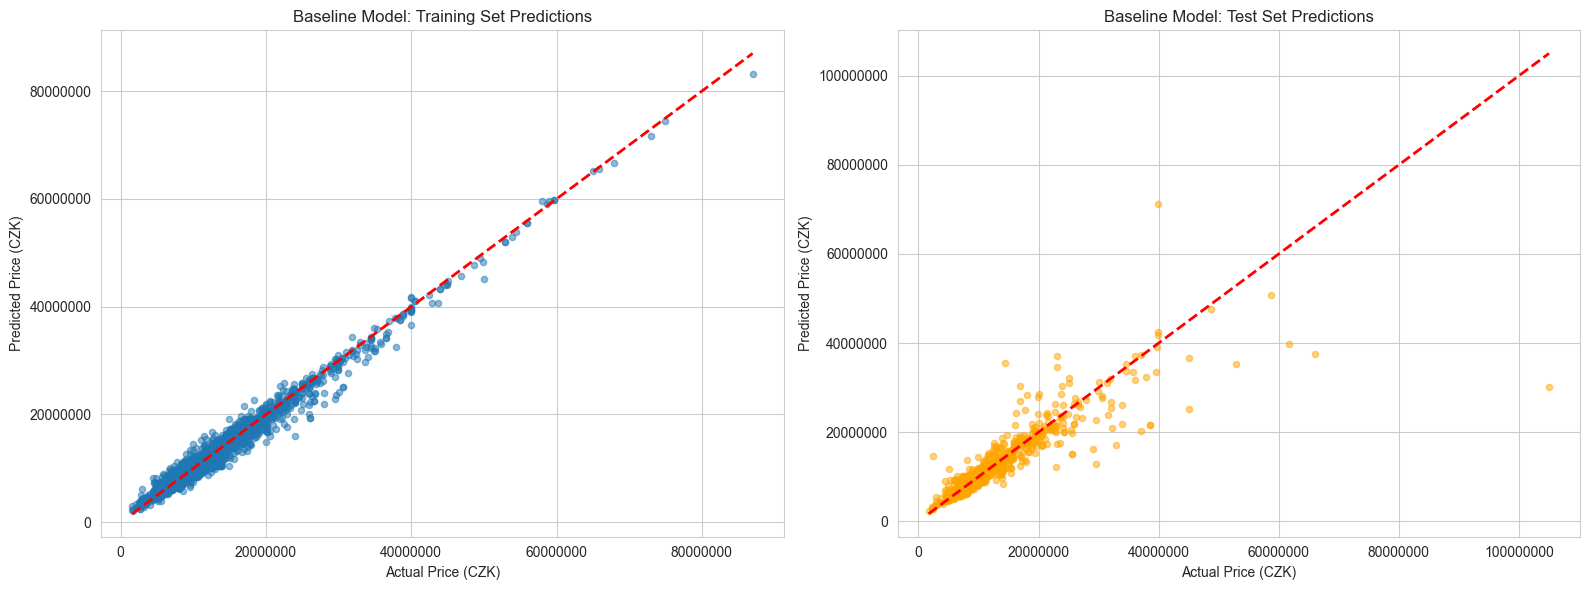

In [45]:
# Prediction vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (CZK)')
axes[0].set_ylabel('Predicted Price (CZK)')
axes[0].set_title('Baseline Model: Training Set Predictions')
axes[0].ticklabel_format(style='plain')

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price (CZK)')
axes[1].set_ylabel('Predicted Price (CZK)')
axes[1].set_title('Baseline Model: Test Set Predictions')
axes[1].ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

In [46]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

print("Starting GridSearchCV hyperparameter tuning...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take several minutes...\n")

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation RMSE: {np.sqrt(-grid_search.best_score_):,.0f} CZK")

Starting GridSearchCV hyperparameter tuning...
Total combinations to test: 972
This may take several minutes...

Fitting 3 folds for each of 972 candidates, totalling 2916 fits

Best parameters found:
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}

Best cross-validation RMSE: 2,699,586 CZK


In [47]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with tuned model
y_pred_train_tuned = best_model.predict(X_train)
y_pred_test_tuned = best_model.predict(X_test)

print("Tuned Model Performance:")
print("=" * 50)
print("\nTraining Set:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_tuned)):,.0f} CZK")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_tuned):,.0f} CZK")
print(f"R² Score: {r2_score(y_train, y_pred_train_tuned):.4f}")

print("\nTest Set:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_tuned)):,.0f} CZK")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_tuned):,.0f} CZK")
print(f"R² Score: {r2_score(y_test, y_pred_test_tuned):.4f}")

# Compare with baseline
print("\n" + "=" * 50)
print("IMPROVEMENT OVER BASELINE:")
print("=" * 50)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_tuned))
improvement = ((baseline_rmse - tuned_rmse) / baseline_rmse) * 100
print(f"RMSE Improvement: {improvement:.2f}%")
print(f"Baseline Test RMSE: {baseline_rmse:,.0f} CZK")
print(f"Tuned Test RMSE: {tuned_rmse:,.0f} CZK")
print()
print(f"R² Improvement: {(r2_score(y_test, y_pred_test_tuned) - untuned_r2) * 100:.2f}%")
print(f"Untuned R²: {untuned_r2:.4f}")
print(f"Tuned R²: {r2_score(y_test, y_pred_test_tuned):.4f}")

Tuned Model Performance:

Training Set:
RMSE: 547,589 CZK
MAE: 374,258 CZK
R² Score: 0.9943

Test Set:
RMSE: 3,816,340 CZK
MAE: 1,451,000 CZK
R² Score: 0.7861

IMPROVEMENT OVER BASELINE:
RMSE Improvement: 8.40%
Baseline Test RMSE: 4,166,139 CZK
Tuned Test RMSE: 3,816,340 CZK

R² Improvement: 4.10%
Untuned R²: 0.7451
Tuned R²: 0.7861


## 6. Final Model Evaluation

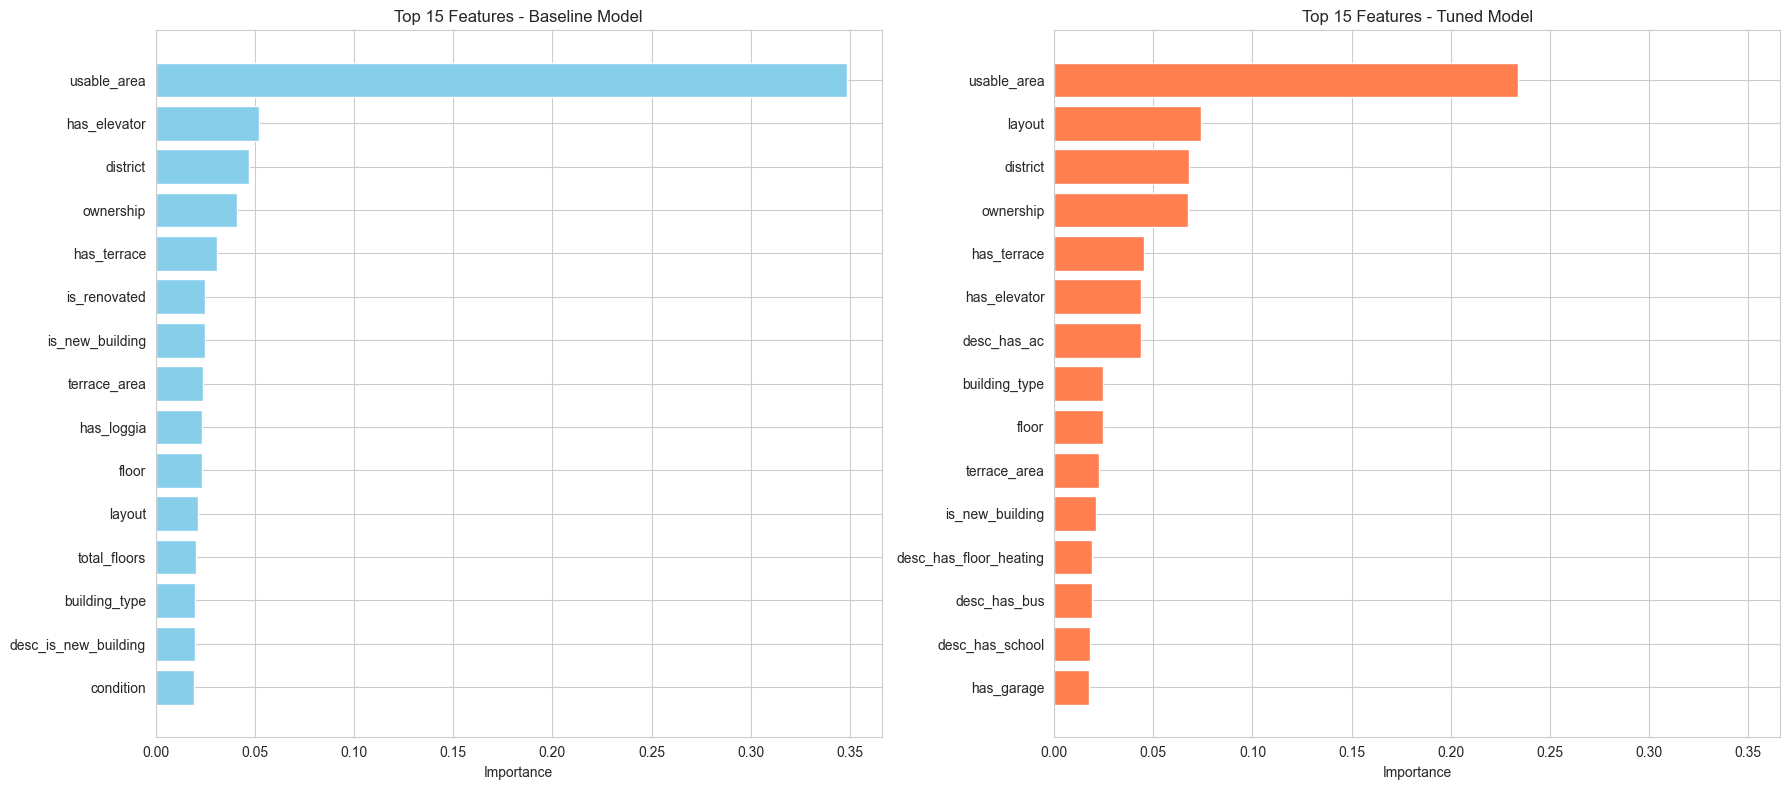

In [48]:
# Updated feature importance for tuned model
feature_importance_tuned = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot comparison of top features
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Baseline model
top_features_baseline = feature_importance.head(15)
axes[0].barh(range(len(top_features_baseline)), top_features_baseline['importance'], color='skyblue')
axes[0].set_yticks(range(len(top_features_baseline)))
axes[0].set_yticklabels(top_features_baseline['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features - Baseline Model')
axes[0].invert_yaxis()

# Tuned model
top_features_tuned = feature_importance_tuned.head(15)
axes[1].barh(range(len(top_features_tuned)), top_features_tuned['importance'], color='coral')
axes[1].set_yticks(range(len(top_features_tuned)))
axes[1].set_yticklabels(top_features_tuned['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features - Tuned Model')
axes[1].invert_yaxis()

# Set same x-axis limits for both plots
max_importance = max(top_features_baseline['importance'].max(), top_features_tuned['importance'].max())
axes[0].set_xlim(0, max_importance * 1.05)
axes[1].set_xlim(0, max_importance * 1.05)

plt.tight_layout()
plt.show()

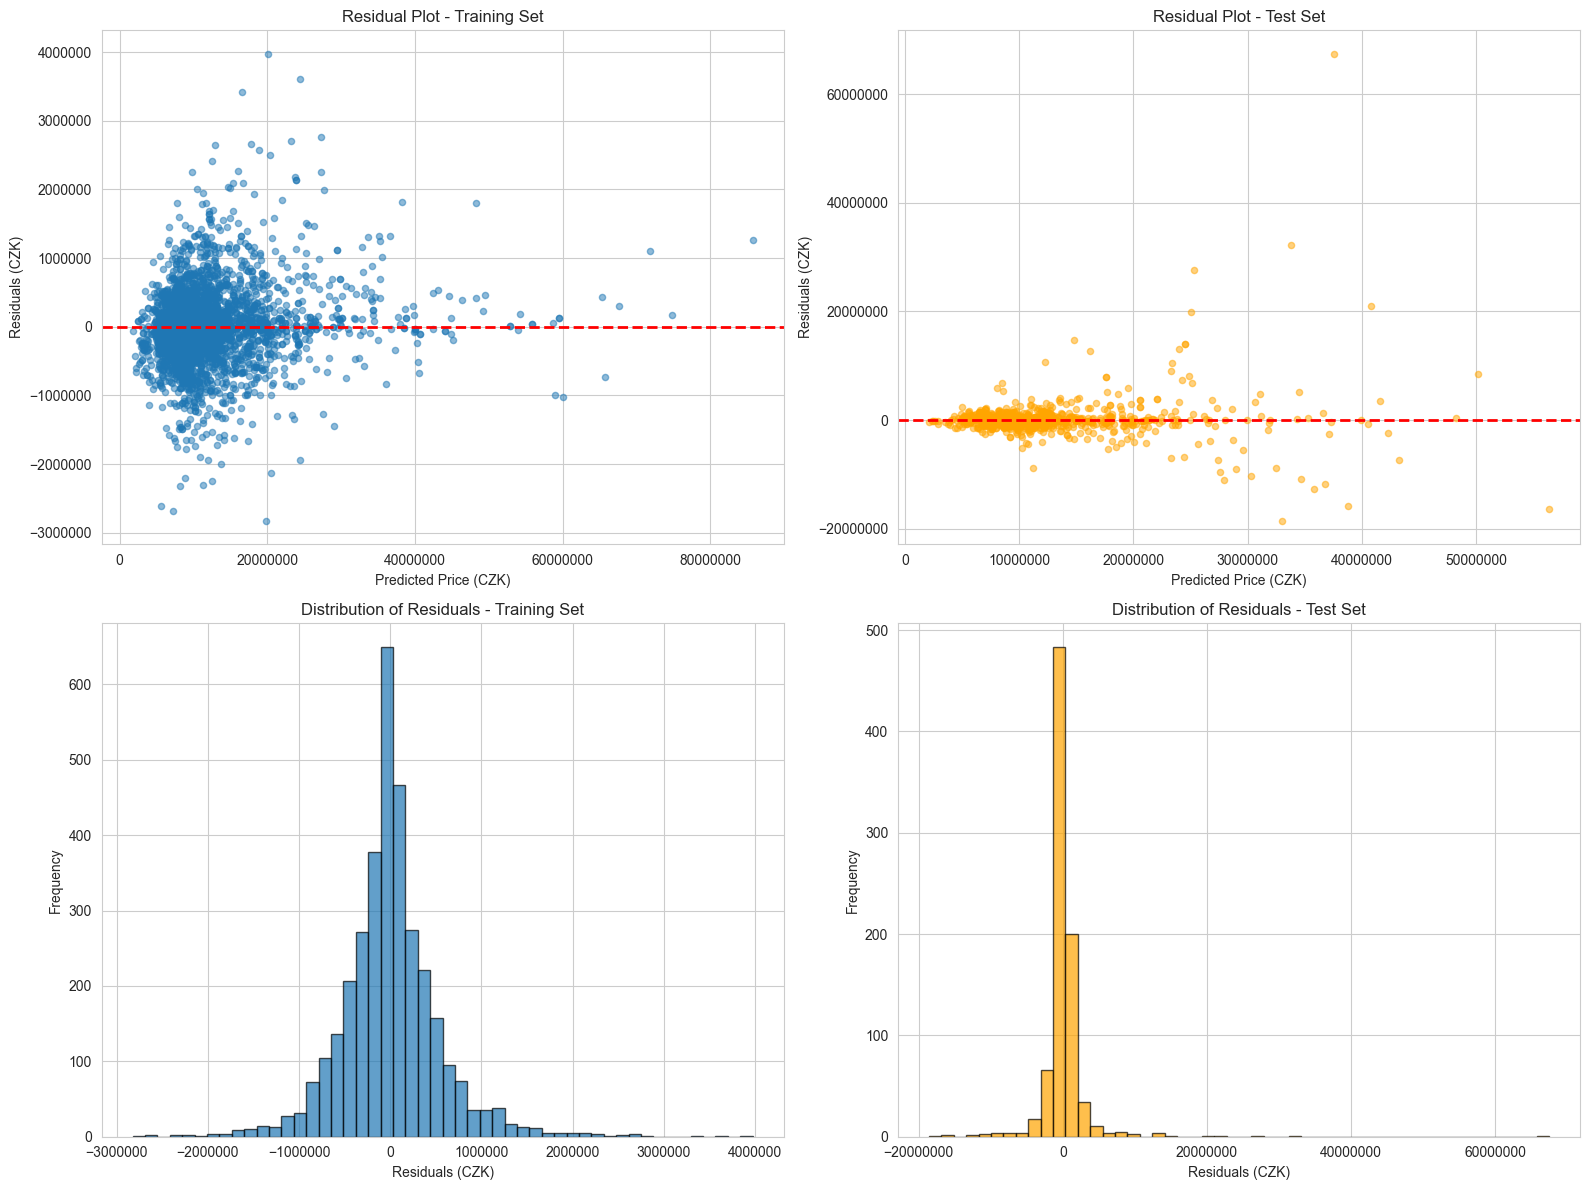

In [49]:
# Residual analysis
residuals_train = y_train - y_pred_train_tuned
residuals_test = y_test - y_pred_test_tuned

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Predicted (Train)
axes[0, 0].scatter(y_pred_train_tuned, residuals_train, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Price (CZK)')
axes[0, 0].set_ylabel('Residuals (CZK)')
axes[0, 0].set_title('Residual Plot - Training Set')
axes[0, 0].ticklabel_format(style='plain')

# Residuals vs Predicted (Test)
axes[0, 1].scatter(y_pred_test_tuned, residuals_test, alpha=0.5, s=20, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price (CZK)')
axes[0, 1].set_ylabel('Residuals (CZK)')
axes[0, 1].set_title('Residual Plot - Test Set')
axes[0, 1].ticklabel_format(style='plain')

# Residual distribution (Train)
axes[1, 0].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals (CZK)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals - Training Set')
axes[1, 0].ticklabel_format(style='plain')

# Residual distribution (Test)
axes[1, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Residuals (CZK)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals - Test Set')
axes[1, 1].ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

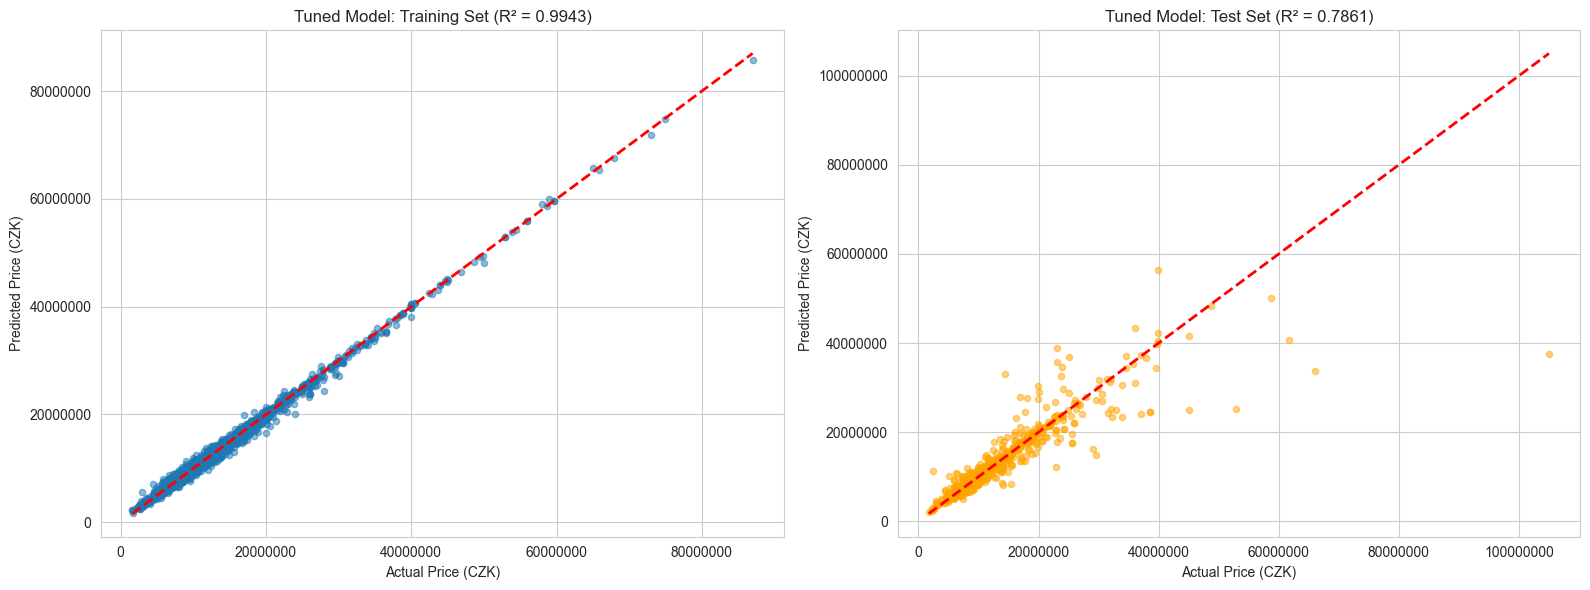

In [50]:
# Final predictions vs actual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_pred_train_tuned, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (CZK)')
axes[0].set_ylabel('Predicted Price (CZK)')
axes[0].set_title(f'Tuned Model: Training Set (R² = {r2_score(y_train, y_pred_train_tuned):.4f})')
axes[0].ticklabel_format(style='plain')

# Test set
axes[1].scatter(y_test, y_pred_test_tuned, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price (CZK)')
axes[1].set_ylabel('Predicted Price (CZK)')
axes[1].set_title(f'Tuned Model: Test Set (R² = {r2_score(y_test, y_pred_test_tuned):.4f})')
axes[1].ticklabel_format(style='plain')

plt.tight_layout()
plt.show()